# `PMOIRED` example #5: How to model spectral lines

We will analyse the GRAVITY data on the eclipsing binary [$\omicron$ Leo](https://simbad.cds.unistra.fr/simbad/sim-id?Ident=omi+Leo&submit=submit+id) published in [Gallenne et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...672A.119G/abstract). The spectroscopic binary is a SB2, which means both components' lines are seen in the spectra. The 2023 publication only reports on the multi-epochs astrometric measurements (i.e. relative position). In this tutorial, we will go a bit further and model the spectroscopic brackett $\gamma$ line and compare the velocity derived from GRAVITY with the orbital fit to high-resolution spectroscopy. In details, we will:
- [Load and display data](#load)
- [Correct the spectrum for telluric absorption](#tellurics)
- [Find the separation vector, using spectraly-binned data and a grid search](#grid)
- [Add spectroscopic lines to the binary model to measure the orbital velocity](#brackettgamma)
- [Analyse all epochs, saving sessions for each epoch](#allepochs)
- [Compare orbit with original publication](#orbit)

In [1]:
# -- uncomment to get interactive plots
#%matplotlib widget
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pickle

import pmoired
from pmoired import tellcorr

# -- in case you want to limit the number of cores for the multiprocessing functions
# -- will take all CPUs otherwise! 
# pmoired.MAX_THREADS = 8 
print('will use', pmoired.MAX_THREADS, 'CPUs for multiprocessing')

will use 12 CPUs for multiprocessing


# Initial loading and displaying data <a id='load'></a>

GRAVITY files contain at least 2 "instruments": the fringe tracker (`GRAVITY_FT`) and the science spectrograph (`GRAVITY_SC`). This is why we need to indicate which instrument to load. Otherwise, all instruments are loaded by default. If you need to load data taken with the polarisation mode, use:
```
>>> oi = pmoired.OI(filename, insname='GRAVITY_SC_P1')
>>> oi.addData(filename, insname='GRAVITY_SC_P2')
```

Because of the large number of spectral channels, the data are shown in "spectral" mode: this is very practical when inspecting/modeling spectral lines. We can see strong non-0 closure phase, as well as visibility which depends both on the length and orientation of the baselines. This can be better seen by plotting data as function of spatial frequency (B/$\lambda$), by using `oi.show(spectro=False)`.

In the FLUX window: it has a lot of features, but most of them are none astrophysical:
- the flux still contains the instrumental transmission (e.g. the drop in transmission around $\lambda$=2.2$\mu$m is due to the silicate fibers). This can be automatically corrected using the option `flat-flux=true` while reducing the data. We can check with `oi.getESOPipelineParams()` that it was not the case (if you want to access the parameters of the recipes, they are in `oi.data[0]['recipes']` for the first data file and so one)
- There are a lot of telluric features which appear as many fine lines, mostly in absorption. `PMOIRED` contains a telluric correction routine for GRAVITY data, based on a [HITRAN](https://www.eso.org/sci/publications/messenger/archive/no.142-dec10/messenger-no142-21-24.pdf) models, the same used in the much more compete ESO tool [Molecfit](http://www.eso.org/sci/software/pipelines/skytools/molecfit).

The tellurics do not affect the interferometric quantities (visibilities, phases, etc.). If you do *not* use the spectrum, it is not necessary to correct for tellurics!

_Here we load data without telluric correction (`tellurics=False` in `pmoired.OI`), which has already been computed, below we explain how this is done. In general, omit this option which is here only for the sake of demonstration!_

loadOI: loading DATA/o_Leo/GRAVI.2022-02-28T042658.272_singlescivis_singlesciviscalibrated.fits
  > insname: "GRAVITY_SC" targname: "omi_Leo" pipeline: "GRAVITY pipeline 1.5.0"
  > MJD: (1,) [ 59638.18598440278 .. 59638.18598440278 ]
  > A0-G1-J2-K0 | WL: (1628,) [ 1.97 .. 2.4 ] um (R~4134) {'FLUX': 4, 'T3': 4, 'VIS': 6, 'VIS2': 6} | TELL: IGNORED! 


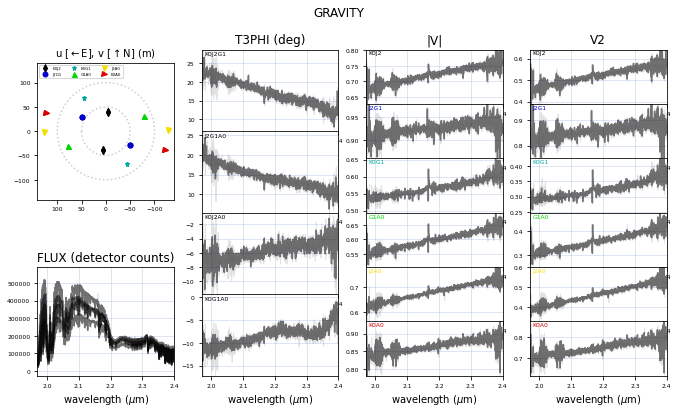

In [2]:
d = 'DATA/o_Leo/'
files = sorted([os.path.join(d, f) for f in os.listdir(d) if f.endswith('calibrated.fits')])
oi = pmoired.OI(files[0], insname='GRAVITY_SC', tellurics=False)
oi.show()

In [3]:
oi.getESOPipelineParams()

= DATA/o_Leo/GRAVI.2022-02-28T042658.272_singlescivis_singlesciviscalibrated.fits ==================== 
REC1 gravity_vis [GRAVITY Instrument Pipeline 1.5.0] GRAVI.2022-02-28T04:26:58.272.fits (SINGLE_SCI_RAW), GRAVI.2022-02-28T04:28:52.277.fits (SINGLE_SKY_RAW), GRAVI.2022-02-28T10:16:11.220_dark.fits (DARK), GRAVI.2022-02-16T12:47:16.321_bad.fits (BAD), GRAVI.2022-02-16T12:48:52.325_flat.fits (FLAT), GRAVI.2022-02-16T12:53:40.337_wave.fits (WAVE), GRAVI.2022-02-16T13:03:01.361_p2vm.fits (P2VM), GRAVI_DISP_MODEL_2019-10-17.fits (DISP_MODEL), GRAVI_DIODE_POSITION.fits (DIODE_POSITION), M.GRAVITY.2017-03-29T11:53:36.950.fits (DIAMETER_CAT)
static-name=false bias-subtracted-file=false spectrum-file=false preproc-file=false p2vmreduced-file=false astro-file=true average-vis=false bias-method=MASKED_MEDIAN_PER_COLUMN acq-correction-delay=0.25 use-fiber-dxy=false use-met-rtc=false chi2r-threshold=50 chi2r-sigma=100 nsmooth-snr-ft=5 snr-min-ft=3 global-state-min-ft=2 global-state-max-ft=4 sta

# Correcting for tellurics Lines <a id='tellurics'></a>

`PMOIRED` library `tellcorr` allows a simple telluric correction for GRAVITY data. It is not as complete as [Molecfit](http://www.eso.org/sci/software/pipelines/skytools/molecfit) which performs a fit of all molecular species in the Earth's atmosphere, here we just interpolate in a 1D grid of models parametrised by the precipitable water vapour. The function `gravity` also need to fit the continuum shape and a refined spectral dispersion model. Thanks to this, [Gallenne et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...672A.119G/abstract) showed that the original spectral calibration of GRAVITY_HR is accurate to 0.02%.

The telluric model is written in the OIFITS files as an additional extension (`TELLURICS`) which contains the telluric model, the corrected spectra as well as the calibrated spectral dispersion model. The header of the `TELLURICS` extension contains a keyword `PWV` which is the fitted precipitable water vapour (in mm). The columns are:
* 'EFF_WAVE'  ; format = 'D'; unit = 'm' -> wavelength as listed in the original file
* 'RAW_SPEC'  ; format = 'D' -> spectrum, weighted mean of the telescopes 
* 'TELL_TRANS'; format = 'D' -> adjusted telluric transmission
* 'CORR_SPEC' ; format = 'D' -> corrected spectrum (i.e. removing the tellurics, but not the continuum)
* 'CORR_WAVE' ; format = 'D'; unit = 'm' -> fitted wavelength table
* 'CORR_CONT' ; format = 'D' -> crude continuum model, fitted using splines 

Functions in library `tellcorr`:
- `gravity` to correct GRAVITY files
- `showTellurics` to show the model applied to a given file
- `removeTellurics` to remove the FITS `TELLURICS` extension in the file

_This computation for all epochs is quite long, even though it is parallelised. For convenience, data for the tutorial are provided with telluric correction computed because there are no parameters to adjust by users..._

In [4]:
from multiprocessing import Pool

# -- remove tellurics
#with Pool(pmoired.MAX_THREADS) as p:
#    p.map(tellcorr.removeTellurics, files)

# -- (re)compute tellurics
with Pool(pmoired.MAX_THREADS) as p:
    p.map(tellcorr.gravity, files)

tellurics already computed for DATA/o_Leo/GRAVI.2023-01-27T061514.299_singlescivis_singlesciviscalibrated.fits use "force=True" to recompute
tellurics already computed for DATA/o_Leo/GRAVI.2022-04-02T033609.520_singlescivis_singlesciviscalibrated.fits use "force=True" to recompute
tellurics already computed for DATA/o_Leo/GRAVI.2022-03-31T024957.441_singlescivis_singlesciviscalibrated.fits use "force=True" to recompute
tellurics already computed for DATA/o_Leo/GRAVI.2022-03-30T022042.484_singlescivis_singlesciviscalibrated.fits use "force=True" to recompute
tellurics already computed for DATA/o_Leo/GRAVI.2022-03-25T022643.337_singlescivis_singlesciviscalibrated.fits use "force=True" to recompute
tellurics already computed for DATA/o_Leo/GRAVI.2022-04-01T030637.299_singlescivis_singlesciviscalibrated.fits use "force=True" to recompute
tellurics already computed for DATA/o_Leo/GRAVI.2022-03-02T053953.466_singlescivis_singlesciviscalibrated.fits use "force=True" to recompute
tellurics alr

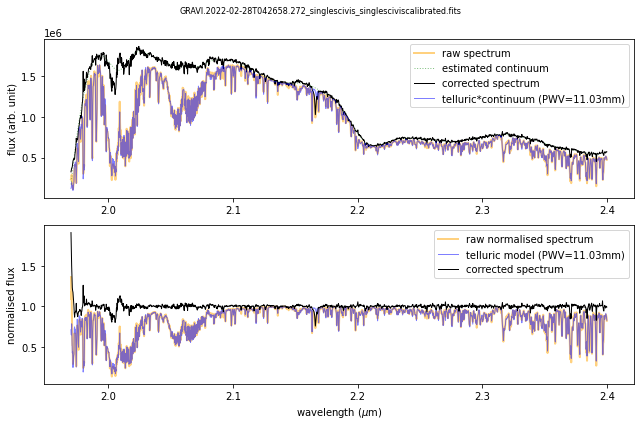

In [5]:
tellcorr.showTellurics(files[0], fig=100)

## Reloading data

From now on, `PMOIRED` will automatically take into account the telluric correction: if you want to use the tellurics wavelength calibration, you need to specify `useTelluricsWL=True`. This is not necessary as the GRAVITY spectral calibration is accurate to ~0.02% in HR.

To make sure the tellurics are taken into account, you can see in the text output, at the end of the line: `TELL: True pwv=3.18mm`.

_Note that the corrected spectrum still shows the continuum (dominated by the instrumental signature): the continnum is fitted only when using a model which has explicit spectral lines._

In [6]:
oi = pmoired.OI(files[0], insname='GRAVITY_SC')

loadOI: loading DATA/o_Leo/GRAVI.2022-02-28T042658.272_singlescivis_singlesciviscalibrated.fits
  > insname: "GRAVITY_SC" targname: "omi_Leo" pipeline: "GRAVITY pipeline 1.5.0"
  > MJD: (1,) [ 59638.18598440278 .. 59638.18598440278 ]
  > A0-G1-J2-K0 | WL: (1628,) [ 1.97 .. 2.4 ] um (R~4134) {'FLUX': 4, 'T3': 4, 'VIS': 6, 'VIS2': 6} | TELL: True pwv=11.03mm


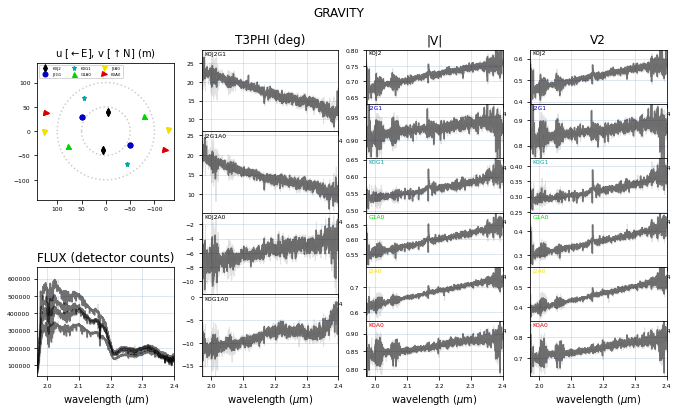

In [7]:
oi.show()

# Grid search to find binary separation <a id='grid'></a>

We already know that the system is a binary (from spectroscopy), but we can learn a little bit more by looking at the GRAVITY data:
- The visibility of a binary system composed of two unresolved stars $A$ and $B$ will vary between 1 and $(f_A-f_B)/(f_A+f_B)$ if $f_A$ is the flux of the primary (the brightest component) and $f_B$ the flux of the secondary. We see that $|V|$ reaches a minimum of 0.5 (for baseline J2A0 and J3J2), indicating that $f_B/f_A\approx0.3$
- The visibility of the binary is a sinusoidal wave $sin(2\pi \vec{B}.\vec{S}/\lambda)$ where $\vec{B}$ is the projected baseline and $\vec{S}$ the separation vector. For our data, we do not see a full cycle of the visibility, so $|\vec{B}.\vec{S}/\lambda_{min} - \vec{B}.\vec{S}/\lambda_{max}|<<1$, which leads to $S\lesssim\frac{\lambda^2}{B(\lambda_{max}-\lambda_{min})}=25mas$ (assuming B$\approx$100m).

To find the best fit model, we use a simple binary model with 2 unresolved stars (`'ud':0.1`). By default, the flux and position of `A` is assumed to be 1 and (0,0) respectively. Because we do not need the full spectral resolution, we can bin the data spectrally to make the calculations faster (`binning=20` in `pmoired.OI`).

`oi.gridFit` takes parameters an exploration pattern an first parameter (see `?oi.gridfit`) which describes how the parameters will be explored. This can be done via a grid, or randomisation (uniform or normal). In case no grid is defined, then the number of randomisation `Nfits` needs to be defined. We can also use priors and constraints on the parameters: priors apply to the model even during the fit, whereas constraints apply to the initial conditions only. Finally, we can omit some parameters in the fit: here the sizes of the components, which we set to be unresolved ($<<\lambda_\mathrm{min}/B_\mathrm{max}$).

`oi.showGrid` shows the result of grid search:
- '+' and 'x' are the location of the initial guesses: gray '+' means the fit was successful; red 'x' means the fit was not sucessful (i.e. did not converge properly).
- the coloured dots are the final fits. Notes that several inital conditions converge to the same best fit model. The colour of the dot reflects the final $\chi_{red}^2$, and the circled one if the global minimum
- Some useful options: `interpolate=True` show an image of the interpplated surface of the minima $\chi_{red}^2$; `logV=True` plot the $\chi_{red}^2$ in log scale.  

In [8]:
?oi.gridFit

Signature:
oi.gridFit(
    expl,
    Nfits=None,
    model=None,
    fitOnly=None,
    doNotFit=None,
    maxfev=None,
    ftol=None,
    multi=True,
    epsfcn=None,
    prior=None,
    autoPrior=True,
    constrain=None,
    verbose=2,
)
Docstring:
perform "Nfits" fit on data, starting from "model" (default last best fit),
with grid / randomised parameters. Nfits can be determined from "expl" if
"grid" param are defined.

expl = {'grid':{'p1':(0, 1, 0.1), 'p2':(-1, 1, 0.5), ...},
        'rand':{'p3':(0, 1), 'p4':(-np.pi, np.pi), ...},
        'randn':{'p5':(0, 1), 'p6':(np.pi/2, np.pi), ...}}

grid=(min, max, step): explore all values for "min" to "max" with "step"
rand=(min, max): uniform randomized parameter
randn=(mean, std): normaly distributed parameter

parameters should only appear once in either grid, rand or randn

if "grid" are defined, they will define N as:
Nfits = prod_i (max_i-min_i)/step_i + 1

constrain: set of conditions on the grid search. same as prior's syntax,
b

loadOI: loading DATA/o_Leo/GRAVI.2022-02-28T042658.272_singlescivis_singlesciviscalibrated.fits
  > insname: "GRAVITY_SC" targname: "omi_Leo" pipeline: "GRAVITY pipeline 1.5.0"
  > MJD: (1,) [ 59638.18598440278 .. 59638.18598440278 ]
  > A0-G1-J2-K0 | WL: (81,) [ 1.97 .. 2.4 ] um (R~207) (binx20) {'FLUX': 4, 'T3': 4, 'VIS': 6, 'VIS2': 6} | TELL: True pwv=11.03mm
93 grid points not within constraints
Wed Mar 27 15:41:57 2024: running 196 fits on 12 processes
Wed Mar 27 15:42:05 2024: [████████████████████████████████████████████████████████████]196/196   0s   left
Wed Mar 27 15:42:05 2024: it took 7.8s, 0.04s per fit on average [1510.3 fit/minute]
fits to be taken into account: 196 / 196
making list of unique minima...
unique minima: 31 / 196 [~6.3 first guesses / minima]
  few unique minima -> grid too fine / Nfits too large?
------------
best fit: chi2= 340.41281163179855
{'B,f': 0.2877, # +/- 0.0046
'B,x': -1.035, # +/- 0.013
'B,y': 3.664, # +/- 0.036
'A,ud':0.1,
'B,ud':0.1,
}

Corre

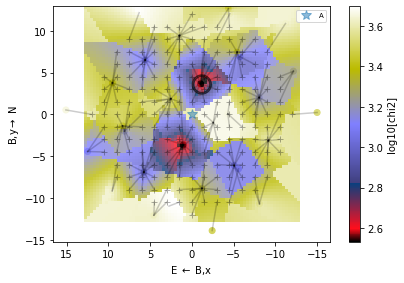

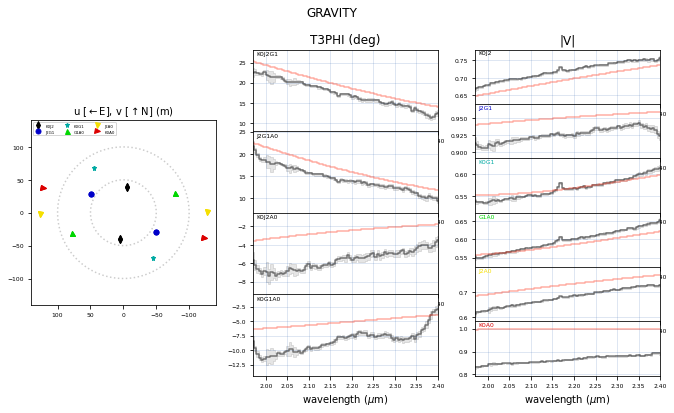

In [9]:
oi = pmoired.OI(files[0], insname='GRAVITY_SC', binning=20)
oi.setupFit({'obs':['|V|', 'T3PHI']})

# -- initial model. A: primary and B:secondary
m = {'A,ud':0.1, 
     'B,ud':0.1, 
     'B,x':3, # value not important, will be updated by gridFit
     'B,y':3, # value not important, will be updated by gridFit
     'B,f':0.6, 
    }

maxSep = 12 # maximum separation in mas
step = 1.5 # step for the search in mas, ~ 0.5 * lambda_min / B_max

expl = {'grid':{'B,x':(-maxSep, maxSep, step), 
                'B,y':(-maxSep, maxSep, step)}
       }
# -- the secondary flux must be lower than the primary, which is 1 by default 
prior = [('B,f', '<', 1)]

# -- this applies to the grid of initial parameters, not to the fit
constrain = [('np.sqrt(B,x**2+B,y**2)', '>', step), 
             ('np.sqrt(B,x**2+B,y**2)', '<', maxSep)]

# -- this is parallelised
oi.gridFit(expl, model=m, doNotFit=['A,ud', 'B,ud'], prior=prior, constrain=constrain)

# -- show the grid result
oi.showGrid(interpolate=True, logV=1, cmap='gist_stern')

# -- show the data and the best fit model
oi.show()


## best fit model from the grid search

we can see that the model is not perfect and tends to somewhat over estimate the visibility: this could be due to the fact the star are actually partially resolved. We can try to re-fit the model but allowing all the parameters to be fitted, including the sizes of the stars, by setting `doNotFit=[]` in `oi.doFit`. By default, if no initial parameters are give to `doFit`, it will use the last best fit model (the one found by `gridFit` above). 

When we show the model, we can also show a synthetic image by giving a field-of-view `imFov` (in mas) for the image (you can give the centre as `imX` and `imY`, in mas).

[dpfit] 5 FITTED parameters: ['A,ud', 'B,f', 'B,ud', 'B,x', 'B,y']
[dpfit] epsfcn= 1e-08 ftol= 1e-05
[dpfit] using scipy.optimize.leastsq
[dpfit] Wed Mar 27 15:42:06 2024 001/000 CHI2: 3.4167e+02|
[dpfit] Both actual and predicted relative reductions in the sum of squares  are at most 0.000010
[dpfit] 44 function calls ( 0.947 ms on average)
# -- degrees of freedom: 810
# -- reduced chi2: 1.660215740225657
{'A,ud':1.2558, # +/- 0.0020
'B,f': 0.25363, # +/- 0.00039
'B,ud':0.666, # +/- 0.014
'B,x': -0.9190, # +/- 0.0010
'B,y': 3.5532, # +/- 0.0029
}

Correlations (%)  >=90 >=80 >=70 >=50 >=20 <20%
         0   1   2   3   4  
 0:A,ud ### -38 -58  33 -20 
 1: B,f -38 ###  43  44 -66 
 2:B,ud -58  43 ###  -9   8 
 3: B,x  33  44  -9 ### -71 
 4: B,y -20 -66   8 -71 ### 


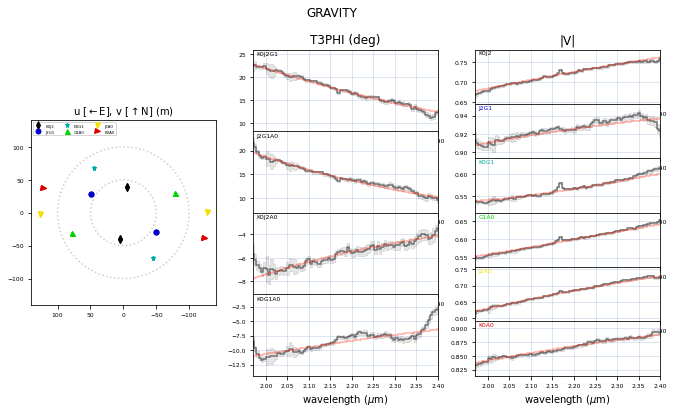

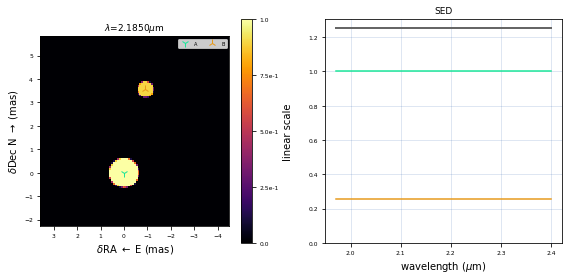

In [10]:
oi.doFit(doNotFit=[])
oi.show(imFov=8, imX=oi.bestfit['best']['B,x']/2, imY=oi.bestfit['best']['B,y']/2)

## bootstrapping to estimate the uncertainties

[Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) is a data resampling method to better estimate uncertainties: many fits are ran where some data are randomly ignored whereas some other are taken into account several times. The data "unit" in `PMOIRED` is one spectral vector of one observable for one telescopes configuration. Data tend to be spectrally correlated, as they are taken all at the same time, from the same telescopes etc. `oi.bootstrapFit` takes at least one parameter `Nfits` the number of fits to perform. If ommited, it will use the number of unique spectral vectors. Note that all parameters of the fit are the same as the last fit you ran: 
- the initial parameters are the last best solution found
- the other parameters, such as `doNotFit`, `prior` etc. are kept as well

`oi.showBootstrap` shows a corner plot with all fitted parameters. Often, the uncertainities from bootstrapping are larger than the one from a single fit: this is because a single fit assumes all uncertainites in the data are uncorrelated, which is not true in practice. `PMOIRED` bootstrapping sampling (by spectral vector) makes it very clear. In practice, uncertainties by bootstrapping should be prefered, even though it can be time consuming to estimate them. 

Note that uncertainites in the fit *do not* take into account some sources. For instance, dimensions such as `A,ud`, `B,ud`, `B,x` and `B,y` are known as good as the baseline and spectral calibration of the instrument is. This scaling factor affects all data the same, and need to be properly into account while fitting orbital parameters (see [Gallenne et al. 2023](https://ui.adsabs.harvard.edu/abs/2023A%26A...672A.119G/abstract) for an proper discussion).

In [11]:
oi.bootstrapFit(Nfits=500)

Wed Mar 27 15:42:08 2024: running 500 fits on 12 processes
Wed Mar 27 15:42:20 2024: [████████████████████████████████████████████████████████████]500/500   0s   left
Wed Mar 27 15:42:20 2024: it took 12.8s, 0.03s per fit on average [2342.0 fit/minutes]
using 481 fits out of 500 (sigma clipping 4.50)
{'A,ud': 1.253, # +/- 0.013
'B,f' : 0.2541, # +/- 0.0013
'B,ud': 0.643, # +/- 0.062
'B,x' : -0.9190, # +/- 0.0033
'B,y' : 3.5494, # +/- 0.0089
}
Correlations (%)  >=90 >=80 >=70 >=50 >=20 <20%
         0   1   2   3   4  
 0:A,ud ### -55  16  43 -12 -11 
 1: B,f -55 ###  29  21 -45  -7 
 2:B,ud  16  29 ###  11  10   4 
 3: B,x  43  21  11 ### -64 -18 
 4: B,y -12 -45  10 -64 ###  -6 


ellipse (emin, emax, PA) for B,x/B,y: 0.0025 0.0091 -14.5


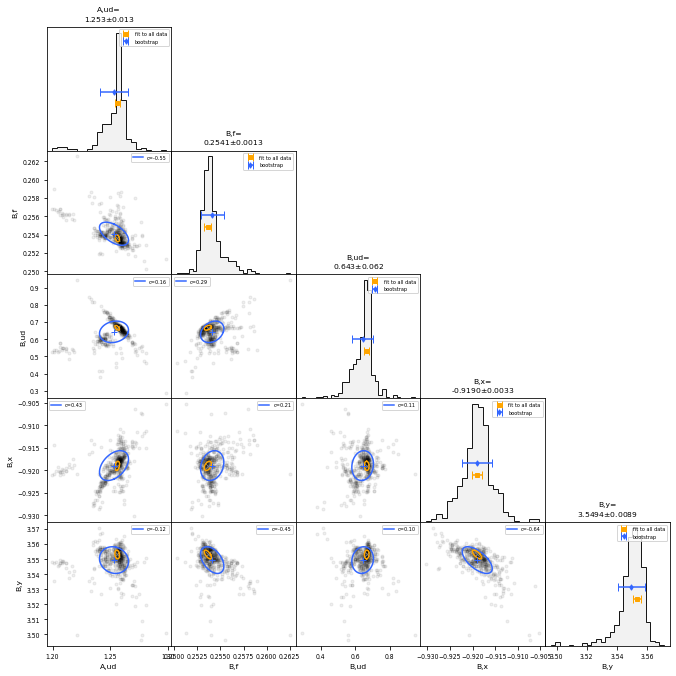

In [12]:
oi.showBootstrap()

# Modeling the Brackett $\gamma$ spectral features <a id='brackettgamma'></a>

The binary is composed of intermediate mass main sequence stars. As such, they show hydrogen absorption features in their spectrum, which shows up in GRAVITY data for the Brackett $\gamma$ line around $\lambda\sim$2.166$\mu$m. In `oi.setupFit`, we can give a list of wavelength ranges ($\lambda_\mathrm{min}$, $\lambda_\mathrm{max}$) to be considered. Strictly speaking, one does not need to reduce the data ranges but this helps the analysis by:
- showing only data around the considered spectral feature
- balance the amount of data in the continuum vs. in the spectral feature. If too much continuum is used, then the fit of the spectral feature might not work as it does not affect the $\chi^2$ enough.

To add a spectral line to a `PMOIRED` model, one should use parameters (where `?` can by any string, which allows to define several lines for a given component): 

- `line_?_wl0`: the central wavelength in $\mu$m
- `line_?_gaussian` or `line_?_lorentzian`: the full width at half maximum (FWHM), in $nm$ (not $\mu$m!!!) for a Gaussian or Lorentzian profiles. 
- `line_?_f` the peak amplitude of the line, <0 for absorption lines and >0 for emission lines

Since we are going to consider spectral lines, we can now fit differential/normalise quantities. 
- `DPHI` is the differential phase, i.e. the visibility's phase minus the continum value.
- `NFLUX` is the normalised flux, i.e. the flux divided by the continuum. 

Concerning the fitting strategy:
- it is recommended to add a prior on the line FWHM, as a very narrow line will produce no variation of $\chi^2$, rendering the fit incensitive to the line.
- Conversly, since `PMOIRED` defines the continuum is outside all the lines described in the model, very broad and weak lines will result in no continuum left.
- usually, the central wavelength as a very small uncertainty compared to its value, which results in a warning that the parameter might not converge properly: it just takes very long. 
- in `oi.setupFit`, one can define the polynomial order to fit the continuum. the default is 1 for all observable. Here we set to 2 for the `NFLUX` as the continuum is strongly affected by the instrumental response. 

loadOI: loading DATA/o_Leo/GRAVI.2022-02-28T042658.272_singlescivis_singlesciviscalibrated.fits
  > insname: "GRAVITY_SC" targname: "omi_Leo" pipeline: "GRAVITY pipeline 1.5.0"
  > MJD: (1,) [ 59638.18598440278 .. 59638.18598440278 ]
  > A0-G1-J2-K0 | WL: (1628,) [ 1.97 .. 2.4 ] um (R~4134) {'FLUX': 4, 'T3': 4, 'VIS': 6, 'VIS2': 6} | TELL: True pwv=11.03mm
[dpfit] 11 FITTED parameters: ['A,line_brg_f', 'A,line_brg_lorentzian', 'A,line_brg_wl0', 'A,ud', 'B,f', 'B,line_brg_f', 'B,line_brg_lorentzian', 'B,line_brg_wl0', 'B,ud', 'B,x', 'B,y']
[dpfit] epsfcn= 1e-08 ftol= 1e-05
[dpfit] using scipy.optimize.leastsq
[dpfit] Wed Mar 27 15:42:21 2024 001/000 CHI2: 1.5391e+02|
[dpfit] Both actual and predicted relative reductions in the sum of squares  are at most 0.000010 and the relative error between two consecutive iterates is at   most 0.000000
[dpfit] 99 function calls ( 6.297 ms on average)
[dpfit] Parameters ['A,line_brg_wl0', 'B,line_brg_wl0'] may not be converging properly
[dpfit] check

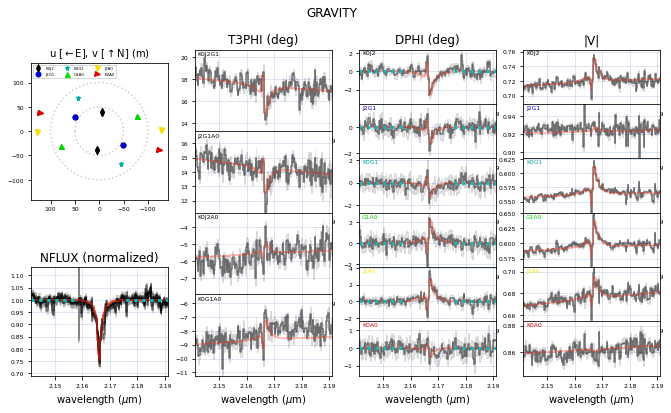

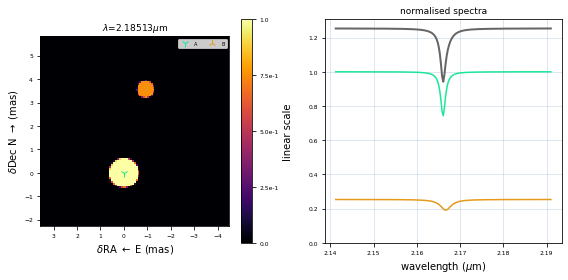

In [13]:
# -- reload data with full spectral resolution
oi = pmoired.OI(files[0], insname='GRAVITY_SC')
# -- limit to wavelength range around BrG, use 2rd order polynomial for flux continuum fit
oi.setupFit({'obs':['|V|', 'T3PHI', 'NFLUX', 'DPHI'],
            'wl ranges':[(2.166-0.025, 2.166+0.025)],
            'NFLUX order':2, 
            })

# -- previous best fit for first epoch, copy/pasted
model = {'A,ud':1.2558, # +/- 0.0020
        'B,f': 0.25363, # +/- 0.00039
        'B,ud':0.666, # +/- 0.014
        'B,x': -0.9190, # +/- 0.0010
        'B,y': 3.5532, # +/- 0.0029
        }

# -- add spectral lines to 'A' and 'B'
model.update(
  {'A,line_brg_wl0':2.166,
  'A,line_brg_f':-0.5,
  'A,line_brg_lorentzian':1.0,   
  'B,line_brg_wl0':2.166,
  'B,line_brg_f':-0.3,
  'B,line_brg_lorentzian':1.0,          
  })

# -- set priors to the lines FWHM to make sure the fit converges properly
prior = [('A,line_brg_lorentzian', '>', 0.5),
         ('A,line_brg_lorentzian', '<', 3),
         ('B,line_brg_lorentzian', '>', 0.5),
         ('B,line_brg_lorentzian', '<', 3),
        ]

oi.doFit(model, prior=prior)

oi.show(imFov=8, imX=oi.bestfit['best']['B,x']/2, imY=oi.bestfit['best']['B,y']/2)

## Re-parametrisation of the wavelength

In the previous fit, we get a warning because the wavelength of the line may not be converging properly. `oi.showFit` shows the evolution of the parameters during the fit: both `line_brg_wl0` for `A` and `B` show little spikes in $\chi^2$, showing that the parameters varies too much. In essence, the gradient descent has trouble fitting a parameter which uncertainty is much smaller that its value (we have typically err/value$\sim$5e-6 for `A,line_brg_wl0`).

To mitigate this, we can re-parametrise the central wavelengths as Doppler shift to the rest wavelength of Brackett $\gamma$. This has also the advantage to give us the radial velocity of each star, which are expected to vary epoch to epoch due to the orbital motion. The fit is much faster to converge, as err/value$\sim$1.7e-2 for `vA`.

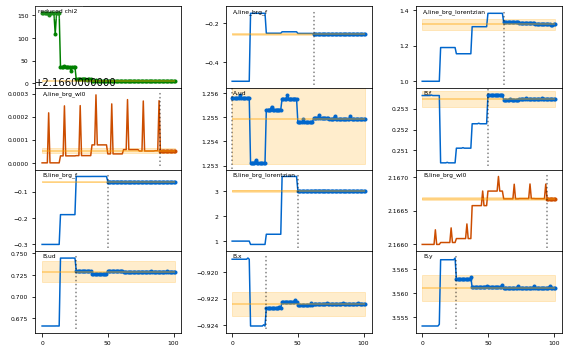

In [14]:
oi.showFit()

[dpfit] 11 FITTED parameters: ['A,line_brg_f', 'A,line_brg_lorentzian', 'A,ud', 'B,f', 'B,line_brg_f', 'B,line_brg_lorentzian', 'B,ud', 'B,x', 'B,y', 'vA', 'vB']
[dpfit] epsfcn= 1e-08 ftol= 1e-05
[dpfit] using scipy.optimize.leastsq
[dpfit] Both actual and predicted relative reductions in the sum of squares  are at most 0.000010
[dpfit] 73 function calls ( 6.303 ms on average)
# -- degrees of freedom: 3211
# -- reduced chi2: 4.381242642146787
{'A,line_brg_f':         -0.2585, # +/- 0.0039
'A,line_brg_lorentzian':1.312, # +/- 0.031
'A,ud':                 1.2549, # +/- 0.0019
'B,f':                  0.25347, # +/- 0.00038
'B,line_brg_f':         -0.06260, # +/- 0.00099
'B,line_brg_lorentzian':2.983, # +/- 0.076
'B,ud':                 0.729, # +/- 0.012
'B,x':                  -0.92239, # +/- 0.00094
'B,y':                  3.5611, # +/- 0.0027
'vA':                   -6.51, # +/- 1.48
'vB':                   81.24, # +/- 3.29
'A,line_brg_wl0':       '2.16612*(1+$vA/2.998e5)',
'B,line_b

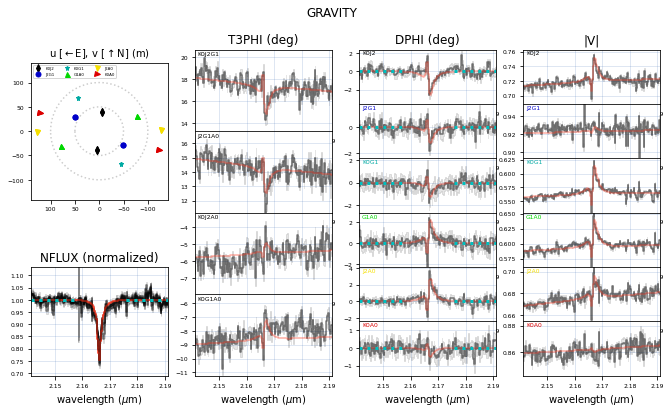

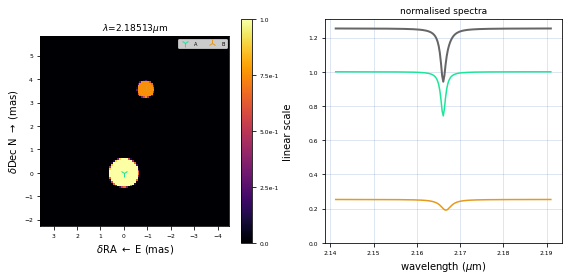

In [15]:
# -- previous best fit, copy/pasted
model = oi.bestfit['best']

# -- Brackett Gamma line wavelength from NIST (microns)
BrG = 2.1661178 

# -- reparametrisation with velocity in km/s
model.update(
  {'A,line_brg_wl0':       '%.5f*(1+$vA/2.998e5)'%BrG, 
  'vA':20, 
  'B,line_brg_wl0':       '%.5f*(1+$vB/2.998e5)'%BrG, 
  'vB':-20, })

prior = [('A,line_brg_lorentzian', '>', 0.5),
         ('A,line_brg_lorentzian', '<', 3),
         ('B,line_brg_lorentzian', '>', 0.5),
         ('B,line_brg_lorentzian', '<', 3),
        ]

oi.doFit(model, prior=prior)

oi.show(imFov=8, imX=oi.bestfit['best']['B,x']/2, imY=oi.bestfit['best']['B,y']/2)

In [16]:
oi.bootstrapFit(Nfits=100)

Wed Mar 27 15:42:26 2024: running 100 fits on 12 processes
Wed Mar 27 15:42:46 2024: [████████████████████████████████████████████████████████████]100/100   0s   left
Wed Mar 27 15:42:46 2024: it took 20.5s, 0.20s per fit on average [292.9 fit/minutes]
using 99 fits out of 100 (sigma clipping 4.50)
{'A,line_brg_f'         : -0.2469, # +/- 0.0056
'A,line_brg_lorentzian': 1.436, # +/- 0.059
'A,line_brg_wl0'       :'2.16612*(1+$vA/2.998e5)',
'A,ud'                 : 1.248, # +/- 0.019
'B,f'                  : 0.2540, # +/- 0.0024
'B,line_brg_f'         : -0.0631, # +/- 0.0011
'B,line_brg_lorentzian': 3.039, # +/- 0.018
'B,line_brg_wl0'       :'2.16612*(1+$vB/2.998e5)',
'B,ud'                 : 0.725, # +/- 0.099
'B,x'                  : -0.9241, # +/- 0.0052
'B,y'                  : 3.560, # +/- 0.015
'vA'                   : -5.68, # +/- 0.31
'vB'                   : 88.9, # +/- 7.1
}
Correlations (%)  >=90 >=80 >=70 >=50 >=20 <20%
                          0   1   2   3   4   5   6   7 

ellipse (emin, emax, PA) for B,x/B,y: 0.0038 0.0152 -14.4


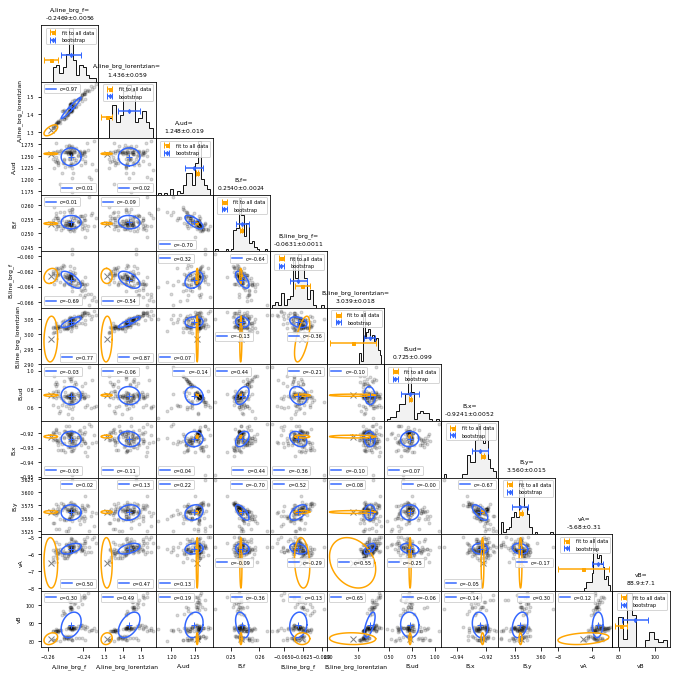

In [17]:
oi.showBootstrap()

# Analysing all epochs <a id='allepochs'></a>

From the single epoch analysis above, we analyse all the epochs:
1) grid search for binary separation and velocity: a regular grid is used for the separation and the velocities are randomised.
2) all parameters are fitted initialising on the best separation and best velocities from the grid
3) Bootstrapping for final uncertainties
4) saving the analysis as a `PMOIRED` binary file
5) saving all models, including the barycentric correction (to take into accout Earth velocity around the Sun), which is computed by `PMOIRED`

_Warning_: this takes a minute or two for each epoch! the binary files with parameters is provided in case this is tool long, so you can jump to the [next section](#orbit)

In [18]:
RES = {} # fits to all epochs, keyed in MJD

for i,f in enumerate(files):
  print('#'*7, 'epoch', i+1, 'of', len(files), '#'*27)
  # -- best model from single epoch analysis above
  model = {'A,line_brg_f':         -0.2484, # +/- 0.0048
    'A,line_brg_lorentzian':0.873, # +/- 0.029
    'A,ud':                 1.2648, # +/- 0.0030
    'B,f':                  0.25193, # +/- 0.00067
    'B,line_brg_f':         -0.0538, # +/- 0.0014
    'B,line_brg_gaussian':  2.286, # +/- 0.095
    'B,ud':                 0.763, # +/- 0.021
    'B,x':                  0, 
    'B,y':                  0, 
    'vA':                   20, # 
    'vB':                   20, # 
    'A,line_brg_wl0':       '2.16612*(1+$vA/2.998e5)',
    'B,line_brg_wl0':       '2.16612*(1+$vB/2.998e5)',
    }
  # -- load data 
  tmp = pmoired.OI(f, insname='GRAVITY_SC')
  # -- limit to wavelength range around BrG
  tmp.setupFit({'obs':['|V|', 'T3PHI', 'NFLUX', 'DPHI'],
               'wl ranges':[(2.166-0.025, 2.166+0.025)],
               'NFLUX order':2, 
               })
  # -- the secondary's flux must be lower than the primary, which is 1 by default 
  prior = [('B,f', '<', 1),
           ('A,line_brg_lorentzian', '>', 0.5),
           ('A,line_brg_lorentzian', '<', 3),
           ('B,line_brg_gaussian', '>', 0.5),
           ('B,line_brg_gaussian', '<', 3),
          ]
  maxSep = 5
  step = 1.5
  constrain = [('np.sqrt(B,x**2+B,y**2)', '>', step), 
               ('np.sqrt(B,x**2+B,y**2)', '<', maxSep)]
  
  expl = {'grid':{'B,x':(-maxSep, maxSep, step), 
                  'B,y':(-maxSep, maxSep, step)},
          'rand':{'vA':(-40, 40), 
                  'vB':(-40, 40)}
         }

  # -- grid-find position and velocity
  tmp.gridFit(expl, model=model, fitOnly=['B,x', 'B,y', 'vA', 'vB'],
             prior=prior, constrain=constrain, verbose=0)
  
  # -- fit all parameters around best model from grid
  tmp.doFit(doNotFit=[], prior=prior, verbose=0) 

  # -- bootstrap fit
  tmp.bootstrapFit(Nfits=100, verbose=0)

  # -- saving result
  tmp.save(os.path.join('DATA/o_Leo', 'oLeo_'+f.split('GRAVI.')[1].split('_')[0]), overwrite=True)
  
  # -- average epoch of the observation
  MJD = np.mean([np.mean(d['MJD']) for d in tmp.data])
    
  # -- save result: best fit, uncertainites and correlations from bootstrapping
  RES[MJD] = {k:tmp.boot[k] for k in ['best', 'uncer', 'covd']}
  # -- average barycentric correction (km/s)
  RES[MJD]['barycorr_km/s'] = np.mean([np.mean(d['barycorr_km/s']) for d in tmp.data])

# -- saving results in binary file
with open(os.path.join('DATA/o_Leo','oLeo_models_allEpochs.dpy'), 'wb') as f:
  pickle.dump(RES, f)

####### epoch 1 of 9 ###########################
loadOI: loading DATA/o_Leo/GRAVI.2022-02-28T042658.272_singlescivis_singlesciviscalibrated.fits
  > insname: "GRAVITY_SC" targname: "omi_Leo" pipeline: "GRAVITY pipeline 1.5.0"
  > MJD: (1,) [ 59638.18598440278 .. 59638.18598440278 ]
  > A0-G1-J2-K0 | WL: (1628,) [ 1.97 .. 2.4 ] um (R~4134) {'FLUX': 4, 'T3': 4, 'VIS': 6, 'VIS2': 6} | TELL: True pwv=11.03mm
Wed Mar 27 15:42:57 2024: [████████████████████████████████████████████████████████████]28/28   0s   left
Wed Mar 27 15:43:17 2024: [████████████████████████████████████████████████████████████]100/100   0s   left
object saved as "DATA/o_Leo/oLeo_2022-02-28T042658.272.pmrd" [size 38.6M]
####### epoch 2 of 9 ###########################
loadOI: loading DATA/o_Leo/GRAVI.2022-03-02T053953.466_singlescivis_singlesciviscalibrated.fits
  > insname: "GRAVITY_SC" targname: "omi_Leo" pipeline: "GRAVITY pipeline 1.5.0"
  > MJD: (1,) [ 59640.236632550914 .. 59640.236632550914 ]
  > A0-G1-J2-J3 | W

## Reloading one of the epoch

Only available if you ran the cell above (analysing all epochs)

['DATA/o_Leo/oLeo_2022-02-28T042658.272.pmrd',
 'DATA/o_Leo/oLeo_2022-03-02T053953.466.pmrd',
 'DATA/o_Leo/oLeo_2022-03-25T022643.337.pmrd',
 'DATA/o_Leo/oLeo_2022-03-26T030236.413.pmrd',
 'DATA/o_Leo/oLeo_2022-03-30T022042.484.pmrd',
 'DATA/o_Leo/oLeo_2022-03-31T024957.441.pmrd',
 'DATA/o_Leo/oLeo_2022-04-01T030637.299.pmrd',
 'DATA/o_Leo/oLeo_2022-04-02T033609.520.pmrd',
 'DATA/o_Leo/oLeo_2023-01-27T061514.299.pmrd']

loading session saved in DATA/o_Leo/oLeo_2022-03-31T024957.441.pmrd
ellipse (emin, emax, PA) for B,x/B,y: 0.0039 0.0054 -28.6
chi2 = 2.864779
{'A,line_brg_f':         -0.2704, # +/- 0.0047
'A,line_brg_lorentzian':1.106, # +/- 0.031
'A,ud':                 1.2662, # +/- 0.0018
'B,f':                  0.24975, # +/- 0.00037
'B,line_brg_f':         -0.05725, # +/- 0.00089
'B,line_brg_gaussian':  3.049, # +/- 0.027
'B,ud':                 0.725, # +/- 0.012
'B,x':                  1.11382, # +/- 0.00094
'B,y':                  4.32133, # +/- 0.00089
'vA':                   -6.44, # +/- 1.45
'vB':                   108.03, # +/- 3.74
'A,line_brg_wl0':       '2.16612*(1+$vA/2.998e5)',
'B,line_brg_wl0':       '2.16612*(1+$vB/2.998e5)',
}

Correlations (%)  >=90 >=80 >=70 >=50 >=20 <20%
                          0   1   2   3   4   5   6   7   8   9  10  
 0:         A,line_brg_f ###  58  -1  -1  15   2   1   1   0   7  22 
 1:A,line_brg_lorentzian  58 ###  -1  -8 -20   4   1   1   0   2  -1 


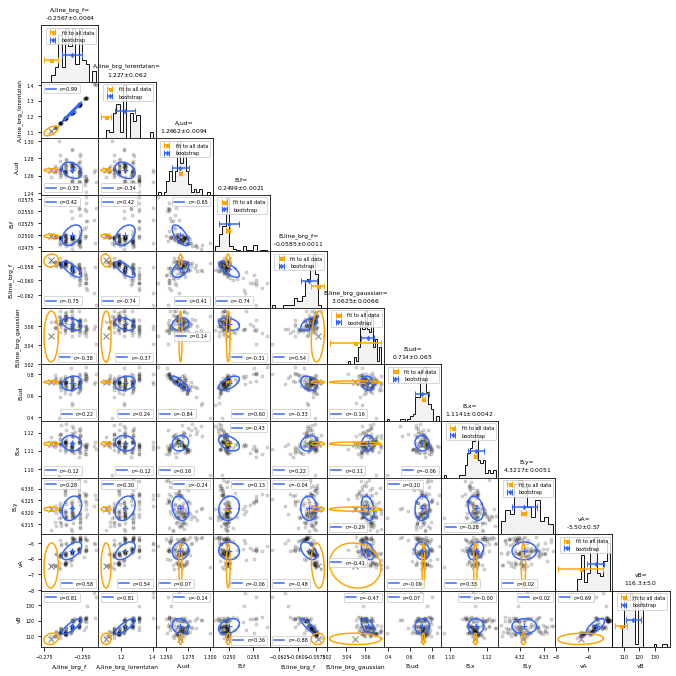

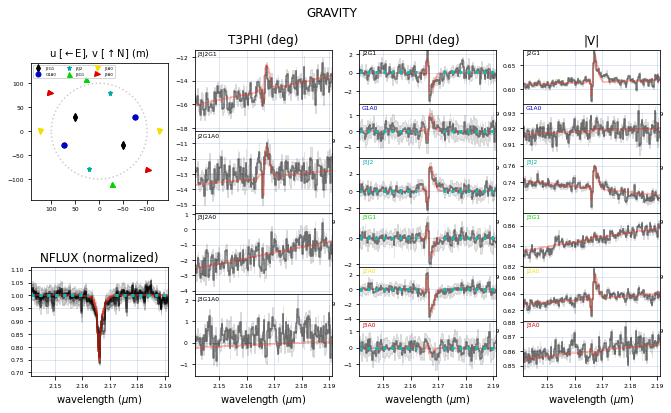

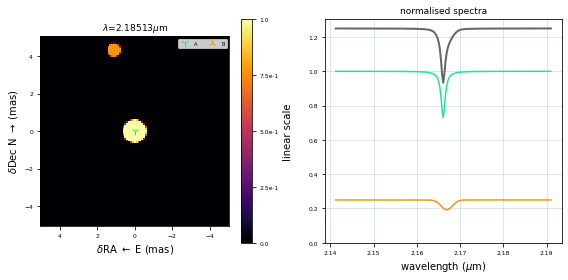

In [19]:
filesb = list(filter(lambda x: x.endswith('.pmrd'), os.listdir('DATA/o_Leo')))
display(filesb)
if len(filesb)>0:
    filesb = sorted([os.path.join('DATA/o_Leo', f) for f in filesb])
    tmp = pmoired.OI(filesb[-1])
    tmp.fig=50
    tmp.showBootstrap()
    tmp.showBestfit()
    tmp.show(imFov=10)

# Orbital parameters <a id='orbit'></a>

We finally take all the epochs together and compare the orbital fit to the one in [Gallenne et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...672A.119G/abstract), who used UVES radial velocities and not the ones from GRAVITY: the former are much more precise than the later, as UVES has much higher spectral resolution than GRAVITY. 

The plot is to be compared with the bottom panels of [Gallenne et al. (2023), figure 4](https://www.aanda.org/articles/aa/full_html/2023/04/aa45712-22/F4.html). 

There is an option to fit our own orbital parameters, but they are quite unreliable as our radial velocities are quite noisy for the secondary `B`.

$\omicron$~Leo was also observed by [Hummel et al. (2001)](https://ui.adsabs.harvard.edu/abs/2001AJ....121.1623H/abstract) using the interferometer NPOI. The GRAVITY orbit can be compared to [fig. 10](https://iopscience.iop.org/article/10.1086/319391/fulltext/fg10.h.gif?doi=10.1086/319391) of this paper. Note that the uncertainties of GRAVITY are much smaller than the ones from NPOI. 

In [20]:
def orbit(t, P):
    """
    xBA, yBA, VA, VB for binary, in mas, mas, km/s, km/s

    t = [(mjd, 'x'), (mjd, 'y'), (mjd, 'va'), (mjd, 'vb'), ...]

    P = {'P':period in days,
         'MJD0': time of periastron,
         'e': eccentricity,
         'omega': argument of periastron in degrees,
         'OMEGA': longitude of asscend nodes in degrees,
         'i': inclination, in degrees,
         }
    to compute velocities, either:
    'Ma', 'Mb', 'plx', 'gamma': masses (im Msol), parallaxe (mas) [-> will compute 'a'], gamma velocity (km/s)
    
    'a', 'Ka', 'Kb', 'gamma': semi-major axis (mas), velocity amplitudes in km/s and gamma velocity (km/s)
    """
    M = 2*np.pi*(((np.array([x[0] for x in t])-P['MJD0'])/P['P'])%1)
    E = 0
    for i in range(20):
        E = M + P['e']*np.sin(E)
    cos_nu = (np.cos(E)-P['e'])/(1-P['e']*np.cos(E))
    nu = np.arccos(cos_nu)
    nu[np.sin(M)<0] = 2*np.pi-nu[np.sin(M)<0]
    
    if 'Ma' in P and 'Mb' in P and 'plx' in P:
        P['a'] = ((P['Ma']+P['Mb'])*(P['P']/365.25)**2)**(1/3) # in AU
        K = 2*np.pi*P['a']*149597870.*np.sin(P['i']*np.pi/180)/(P['P']*24*3600*np.sqrt(1-P['e']**2)) # km/s
        P['Ka'] = K*P['Mb']/(P['Ma']+P['Mb'])
        P['Kb'] = K*P['Ma']/(P['Ma']+P['Mb'])
        P['a'] *= P['plx'] # in mas
    tmp = {}
    # -- separation vector
    if 'a' in P:
        r = P['a']*(1-P['e']**2)/(1+P['e']*np.cos(nu))
        x, y, z = r*np.cos(nu), r*np.sin(nu), 0
        # -- rotation: argument of periastron
        x, y, z = x*np.cos((180-P['omega'])*np.pi/180) + y*np.sin((180-P['omega'])*np.pi/180), \
                 -x*np.sin((180-P['omega'])*np.pi/180) + y*np.cos((180-P['omega'])*np.pi/180), z
        # -- rotation: inclination
        x, y, z = x, y*np.cos((P['i']+180)*np.pi/180) + z*np.sin((P['i']+180)*np.pi/180), \
                    -y*np.sin((P['i']+180)*np.pi/180) + z*np.cos((P['i']+180)*np.pi/180)
        # -- rotation: ascending node 
        x, y, z = x*np.cos((P['OMEGA']+90)*np.pi/180) + y*np.sin((P['OMEGA']+90)*np.pi/180), \
                 -x*np.sin((P['OMEGA']+90)*np.pi/180) + y*np.cos((P['OMEGA']+90)*np.pi/180), z
        tmp.update({'x':x, 'y':y})
    if 'Ka' in P and 'Kb' in P:
        va = P['Ka']*(np.cos(P['omega']*np.pi/180+nu) + P['e']*np.cos(P['omega']*np.pi/180)) + P['gamma']
        vb = -P['Kb']*(np.cos(P['omega']*np.pi/180+nu) + P['e']*np.cos(P['omega']*np.pi/180)) + P['gamma']
        tmp.update({'va':va, 'vb':vb})
    res = []
    for i,o in enumerate(t):
      res.append(tmp[o[1]][i])
    return np.array(res)  

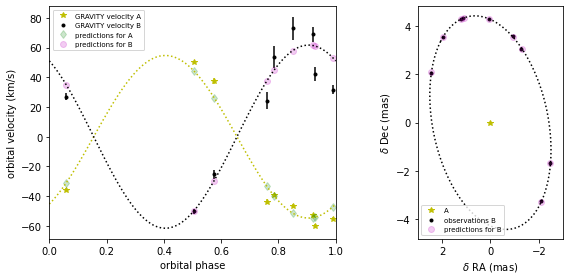

In [21]:
# -- loading results from binary file
with open(os.path.join('DATA/o_Leo/','oLeo_models_allEpochs.dpy'), 'rb') as f:
  RES = pickle.load(f)

# -- orbital parameters from Gallenne+23, table 6
param = {'P':    14.4980686,
         'MJD0': 50623.49, 
         'e':    0.00074, 
         'Ma':   2.07413,
         'Mb':   1.84111,
         'omega':214.22,
         'OMEGA':191.61,
         'i':    57.82, 
         'plx':  24.41281,
         'gamma':26.241,
        }

if False: # -- fit parameters to our data
  # -- recentre times around GRAVITY data:
  param['MJD0'] += param['P']*int((np.mean([mjd for mjd in RES])-param['MJD0'])/param['P'])

  # -- create various data vectors for fit
  input = [(mjd, 'x') for mjd in RES]
  obs = [RES[mjd]['best']['B,x'] for mjd in RES]
  uncer = [RES[mjd]['uncer']['B,x'] for mjd in RES]
  
  input.extend([(mjd, 'y') for mjd in RES])
  obs.extend([RES[mjd]['best']['B,y'] for mjd in RES])
  uncer.extend([RES[mjd]['uncer']['B,y'] for mjd in RES])
  
  input.extend([(mjd, 'va') for mjd in RES])
  obs.extend([RES[mjd]['best']['vA']+RES[mjd]['barycorr_km/s'] for mjd in RES])
  uncer.extend([RES[mjd]['uncer']['vA'] for mjd in RES])
  
  input.extend([(mjd, 'vb') for mjd in RES])
  obs.extend([RES[mjd]['best']['vB']+RES[mjd]['barycorr_km/s'] for mjd in RES])
  uncer.extend([RES[mjd]['uncer']['vB'] for mjd in RES])
  
  fit = pmoired.oimodels.dpfit.leastsqFit(orbit, input, param, obs, uncer, verbose=3, 
                                          doNotFit=['MJD0', 'Ma', 'Mb']
                                         )
  param = fit['best']

plt.close(200)
plt.figure(200, figsize=(9, 4))

# == astrometric orbit ===============================================
ax1 = plt.subplot(122, aspect='equal')
ax1.plot(0, 0, '*y', label='A')
ax1.plot([RES[mjd]['best']['B,x'] for mjd in RES], 
         [RES[mjd]['best']['B,y'] for mjd in RES], 
         '.k', label='observations B')
# -- uncorrelated uncertainities
# ax1.errorbar([RES[mjd]['best']['B,x'] for mjd in RES], 
#              [RES[mjd]['best']['B,y'] for mjd in RES], 
#              xerr=[RES[mjd]['uncer']['B,x'] for mjd in RES],
#              yerr=[RES[mjd]['uncer']['B,y'] for mjd in RES],
#              color='k', linestyle='none', alpha=0.2)
# -- error ellipses:
for mjd in RES:
  ex, ey = pmoired.oimodels.dpfit.errorEllipse(RES[mjd], 'B,x', 'B,y')
  ax1.plot(ex, ey, 'k-', alpha=0.5)

# -- predicted positions
xp = orbit([(mjd, 'x') for mjd in RES], param)
yp = orbit([(mjd, 'y') for mjd in RES], param)
ax1.plot(xp, yp, 'om', alpha=0.2, label='predictions for B')

# -- on full orbit of the model
_phi = np.linspace(0, 1, 100) 
_t = _phi*param['P']+param['MJD0']
_x = orbit([(t, 'x') for t in _t], param)
_y = orbit([(t, 'y') for t in _t], param)
ax1.plot(_x, _y, ':k')

ax1.set_xlim(3, -3)
ax1.set_ylim(-4.8, 4.8)
ax1.set_xlabel(r'$\delta$ RA (mas)')
ax1.set_ylabel(r'$\delta$ Dec (mas)')
ax1.legend(loc='lower left', fontsize=7)

# ==  orbital radial velocity =================================
ax2 = plt.subplot(121)
# -- orbital phase according to Gallenne+ 23, table 6
P, MJD0 = param['P'], param['MJD0'] 
phi = ((np.array(list(RES.keys()))-MJD0)/P)%1

# -- velocity for A
ax2.plot(phi, [RES[mjd]['best']['vA']+RES[mjd]['barycorr_km/s']-param['gamma'] for mjd in RES], '*y', 
         label='GRAVITY velocity A')
ax2.errorbar(phi, [RES[mjd]['best']['vA']+RES[mjd]['barycorr_km/s']-param['gamma'] for mjd in RES], color='y',
            yerr=[RES[mjd]['uncer']['vA'] for mjd in RES], linestyle='none')

# -- velocity for B
ax2.plot(phi, [RES[mjd]['best']['vB']+RES[mjd]['barycorr_km/s']-param['gamma'] for mjd in RES], '.k', 
         label='GRAVITY velocity B')
ax2.errorbar(phi, [RES[mjd]['best']['vB']+RES[mjd]['barycorr_km/s']-param['gamma'] for mjd in RES], color='k',
            yerr=[RES[mjd]['uncer']['vB'] for mjd in RES], linestyle='none')

# -- predicted velocities
phip = [((mjd-param['MJD0'])/param['P'])%1 for mjd in RES]
vap = orbit([(mjd, 'va') for mjd in RES], param)
vbp = orbit([(mjd, 'vb') for mjd in RES], param)
ax2.plot(phip, vap-param['gamma'], 'dg', alpha=0.2, label='predictions for A')
ax2.plot(phip, vbp-param['gamma'], 'om',  alpha=0.2, label='predictions for B')

# -- prediction full orbit
_va = orbit([(t, 'va') for t in _t], param)
plt.plot(_phi, _va-param['gamma'], ':y')
_vb = orbit([(t, 'vb') for t in _t], param)
plt.plot(_phi, _vb-param['gamma'], ':k')

ax2.set_xlim(0,1)
ax2.legend(loc='upper left', fontsize=7)
ax2.set_xlabel('orbital phase')
ax2.set_ylabel('orbital velocity (km/s)')
plt.tight_layout()

## spectral parameters as frunction of time

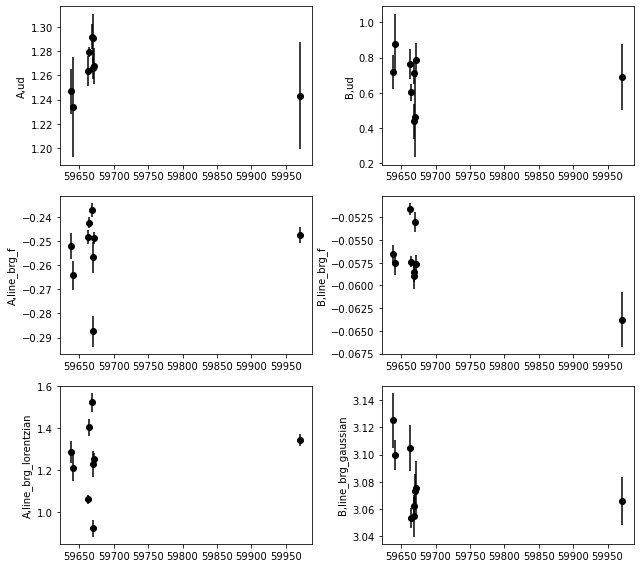

In [22]:
plt.close(201)
plt.figure(201, figsize=(9,8))

O = ['A,ud', 'B,ud', #'B,f',
     'A,line_brg_f',          'B,line_brg_f',
     'A,line_brg_lorentzian', 'B,line_brg_gaussian',]
for i,o in enumerate(O):
  plt.subplot(3,2,i+1)
  plt.plot(RES.keys(), [RES[k]['best'][o] for k in RES], 'ok')
  plt.errorbar(RES.keys(), [RES[k]['best'][o] for k in RES],
               yerr=[RES[k]['uncer'][o] for k in RES],
               color='k', linestyle='none')
  plt.ylabel(o)
plt.tight_layout()